<div style="display: flex; justify-content: center; margin-bottom: 20px;">
  <img src="../docs/_static/seispolarity_logo_title.svg">
</div>

---

# SeisPolarity Prediction API

This notebook demonstrates how to use SeisPolarity's unified prediction interface to perform polarity prediction on seismic waveforms.

## Features
- **Unified Interface**: Single `Predictor` class for all models
- **Automatic Download**: Models and datasets can be downloaded automatically
- **Multiple Models**: Support for ROSS, EQPolarity, DiTingMotion, APP, CFM, PolarCAP, RPNet
- **Flexible Input**: Support for various waveform lengths and formats
- **Comprehensive Metrics**: Confusion matrix, accuracy, and classification report

## List Available Pretrained Models

In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().parent))
from seispolarity.inference import Predictor

# List all available pretrained models with details
models = Predictor.list_pretrained(details=True)

Available pretrained models:

ROSS_SCSN:
  Filename: ROSS_SCSN.pth
  Input Length: 400
  Classes: 3 (Up, Down, Unknown)
  Description: ROSS model: Ross, Z. E., Meier, M. & Hauksson, E. P Wave Arrival Picking and First-Motion Polarity Determination With Deep Learning. JGR Solid Earth 123, 5120-5129 (2018) . Trained on SCSN dataset. 3-class classification (Up, Down, Unknown). Input length: 400 samples.
  Author: Model weights converted and maintained by He XingChen (Chinese, Han ethnicity), `https://github.com/Chuan1937`
-------------------------------------------------------

ROSS_GLOBAL:
  Filename: ROSS_GLOBAL.pth
  Input Length: 400
  Classes: 3 (Up, Down, Unknown)
  Description: ROSS model: Ross, Z. E., Meier, M. & Hauksson, E. P Wave Arrival Picking and First-Motion Polarity Determination With Deep Learning. JGR Solid Earth 123, 5120-5129 (2018) . Trained on global datasets: SCSN , INSTANCE: Michelini, A. et al. INSTANCE-the Italian seismic dataset for machine learning. Earth Syste

## Configuration

In [2]:
import torch

# Device configuration
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Model selection
MODEL_NAME = "ROSS_SCSN"  # Options: ROSS_SCSN, ROSS_GLOBAL, EQPOLARITY_SCSN, etc.

# Dataset configuration
CROP_LEFT = 200  
CROP_RIGHT = 200  
BATCH_SIZE = 2048
PRELOAD = True
ALLOWED_LABELS = [0, 1, 2]  # 0=Up, 1=Down, 2=Unknown

print(f"Device: {DEVICE}")
print(f"Model: {MODEL_NAME}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Preload data: {PRELOAD}")

Device: cuda
Model: ROSS_SCSN
Batch size: 2048
Preload data: True


## Load Dataset

You can either use a local dataset file or download the dataset automatically.

In [3]:
# Option 1: Use local dataset file
TEST_FILE = "/mnt/f/AI_Seismic_Data/scsn/scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5"

# Option 2: Use automatic download (uncomment to use)
# from seispolarity.data import SCSNData
# scsn_processor = SCSNData(output_dir="./datasets")
# TEST_FILE = scsn_processor.download()
# print(TEST_FILE)

# For this example, we'll use a placeholder path
# Replace this with your actual dataset path
print(f"Dataset path: {TEST_FILE}")

Dataset path: /mnt/f/AI_Seismic_Data/scsn/scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5


## Create WaveformDataset

In [4]:
from seispolarity.data import WaveformDataset

dataset = WaveformDataset(
    path=TEST_FILE,
    name="SCSN_Test",
    preload=PRELOAD,
    allowed_labels=ALLOWED_LABELS,
    data_key="X",
    label_key="Y",
    clarity_key=None,
    pick_key=None,  
    metadata_keys=[], 
    p_pick_position=300,     
    crop_left=CROP_LEFT,      
    crop_right=CROP_RIGHT     
)

print(f"Dataset created: {dataset._name}")
print(f"Dataset length: {len(dataset)}")
print(f"Allowed labels: {dataset.allowed_labels}")

2026-02-09 13:54:35,988 - seispolarity.data - INFO - Initialized Flat Dataset from scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5 with 2353054 samples.
2026-02-09 13:54:35,988 | seispolarity.data | INFO | Initialized Flat Dataset from scsn_p_2000_2017_6sec_0.5r_fm_test.hdf5 with 2353054 samples.
2026-02-09 13:54:36,016 - seispolarity.data - INFO - Built index with 2353054 samples (filtered from 2353054)
2026-02-09 13:54:36,016 | seispolarity.data | INFO | Built index with 2353054 samples (filtered from 2353054)
2026-02-09 13:54:36,020 - seispolarity.data - INFO - Loading 2353054 samples into RAM...
2026-02-09 13:54:36,020 | seispolarity.data | INFO | Loading 2353054 samples into RAM...
2026-02-09 13:54:36,023 - seispolarity.data - INFO - Loading Metadata...
2026-02-09 13:54:36,023 | seispolarity.data | INFO | Loading Metadata...
Loading RAM: 100%|██████████| 2353054/2353054 [00:15<00:00, 149785.56samples/s]
2026-02-09 13:54:51,743 - seispolarity.data - INFO - RAM Load Complete.
2026-02-09 13:

Dataset created: SCSN_Test
Dataset length: 2353054
Allowed labels: [0, 1, 2]


## Initialize Predictor

In [5]:
# Initialize predictor
# The model will be automatically downloaded from Hugging Face or ModelScope
predictor = Predictor(
    model_name=MODEL_NAME,
    device=DEVICE
)

# Alternatively, load model from local path
# predictor = Predictor(
#     model_name=MODEL_NAME,
#     model_path="/path/to/local/model.pth",
#     device=DEVICE
# )

print(f"Predictor initialized")
print(f"Model config: {predictor.config_key}")
print(f"Input length: {predictor.config['input_len']}")
print(f"Number of classes: {predictor.config['num_classes']}")
print(f"Class mapping: {predictor.config['class_map']}")

# Use the unified WaveformDataset interface
loader = dataset.get_dataloader(
    batch_size=BATCH_SIZE,  
    num_workers=4 if not PRELOAD else 0, 
    shuffle=False
)

print(f"DataLoader created")
print(f"Number of batches: {len(loader)}")

Using model: ROSS_SCSN (ROSS_SCSN)
Using device: cuda
Checking for model 'ROSS_SCSN.pth' in ./checkpoints_download...
Hugging Face network is not accessible, will use ModelScope.
Attempting download from ModelScope...


2026-02-09 13:54:56,354 - seispolarity.data - INFO - DataLoader: batch=2048, workers=0, shuffle=False, preload=True
2026-02-09 13:54:56,354 | seispolarity.data | INFO | DataLoader: batch=2048, workers=0, shuffle=False, preload=True


Model loaded from ModelScope: ./checkpoints_download/chuanjun/HeXingChen/ROSS/ROSS_SCSN.pth
Weights loaded successfully (strict mode).
Predictor initialized
Model config: ROSS_SCSN
Input length: 400
Number of classes: 3
Class mapping: {0: 'Up', 1: 'Down', 2: 'Unknown'}
DataLoader created
Number of batches: 1149


## Perform Prediction

In [6]:
import numpy as np

# Predict from dataloader
probabilities, labels = predictor.predict_from_loader(loader, return_probs=True)

# Get predictions (argmax of probabilities)
predictions = np.argmax(probabilities, axis=1)

print(f"Prediction completed")
print(f"Number of samples: {len(predictions)}")
print(f"Prediction shape: {predictions.shape}")
print(f"Probability shape: {probabilities.shape}")

Predicting: 100%|██████████| 1149/1149 [00:36<00:00, 31.31batch/s]

Prediction completed
Number of samples: 2353054
Prediction shape: (2353054,)
Probability shape: (2353054, 3)


## Evaluate Results


Confusion Matrix

Confusion Matrix (sample counts):
True\Pred | 0 (Up) | 1 (Down) | 2 (Unknown)
--------------------------------------------------
      0 (Up)     |  498877 |    8403 |   78738 |
      1 (Down)     |    4012 |  246121 |   27000 |
      2 (Unknown)     |  230816 |  213517 | 1045570 |


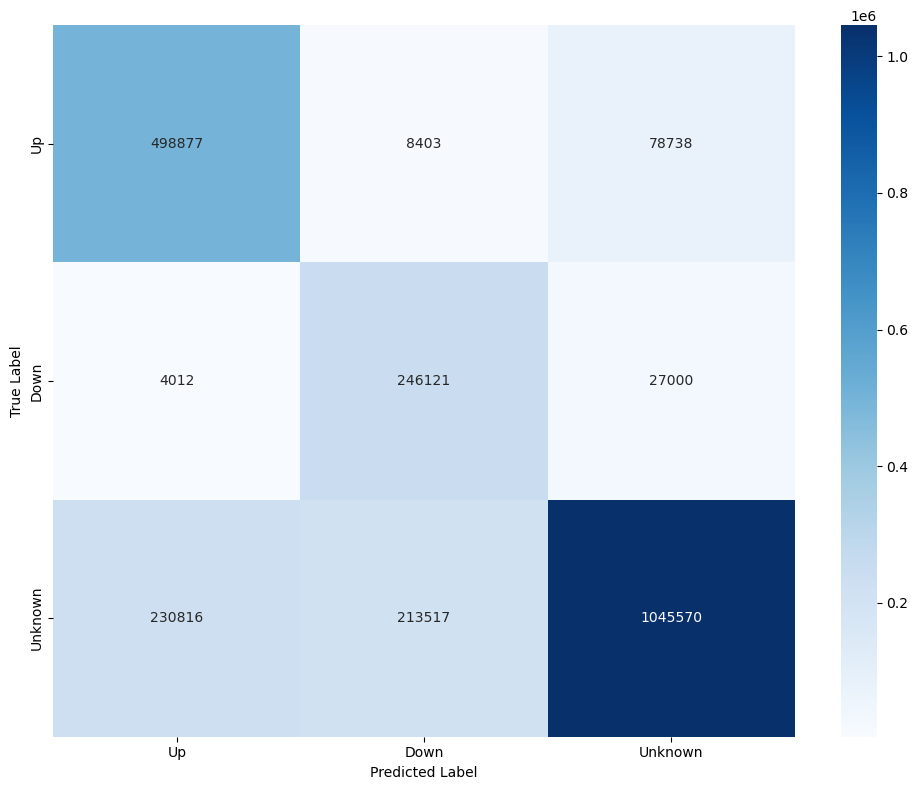

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Compute confusion matrix
cm = confusion_matrix(labels, predictions)

print("\n" + "="*60)
print("Confusion Matrix")
print("="*60)

# Print numerical confusion matrix
print(f"\nConfusion Matrix (sample counts):")
print(f"True\\Pred | 0 (Up) | 1 (Down) | 2 (Unknown)")
print("-" * 50)
for i in range(3):
    label_name = ['Up', 'Down', 'Unknown'][i]
    row_str = f"      {i} ({label_name})     |"
    for j in range(3):
        row_str += f" {cm[i, j]:7d} |"
    print(row_str)

import matplotlib.pyplot as plt
import seaborn as sns

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Up', 'Down', 'Unknown'],
            yticklabels=['Up', 'Down', 'Unknown'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

## Using Different Models

You can easily switch between different pretrained models by changing the `MODEL_NAME` parameter:

In [12]:
# Examples of using different models

# ROSS model (3-class: Up, Down, Unknown)
# predictor_ross = Predictor("ROSS_SCSN", device=DEVICE)

# EQPolarity model (2-class: Up, Down)
# predictor_eq = Predictor("EQPOLARITY_SCSN", device=DEVICE)

# DiTingMotion model (3-class: Up, Down, Unknown)
# predictor_diting = Predictor("DITINGMOTION_DITINGSCSN", device=DEVICE)

# APP model (3-class: Up, Down, Unknown)
# predictor_app = Predictor("APP_SCSN", device=DEVICE)

# CFM model (2-class: Up, Down)
# predictor_cfm = Predictor("CFM_SCSN", device=DEVICE)

# PolarCAP model (2-class: Up, Down)
# predictor_polarcap = Predictor("POLARCAP_SCSN", device=DEVICE)

# RPNet model (2-class: Up, Down)
# predictor_rpnet = Predictor("RPNET_SCSN", device=DEVICE)

# Global models (trained on multiple datasets)
# predictor_global = Predictor("ROSS_GLOBAL", device=DEVICE)

print("See above examples for different model initialization")
print("Use Predictor.list_pretrained(details=True) to see all available models")

See above examples for different model initialization
Use Predictor.list_pretrained(details=True) to see all available models


---

# Seisbench Phase Picker with SeisPolarity First-Motion Polarity Determination

This notebook demonstrates a complete workflow for:
1. **Downloading seismic data** from seismic networks using ObsPy
2. **P-wave picking** using SeisBench models
3. **First-motion polarity determination** using SeisPolarity models

## Workflow Overview

```
Seismic Data (ObsPy) → P-wave Picking (SeisBench) → Polarity Prediction (SeisPolarity)
```

### Key Features
- **Real-world data**: Download seismic waveforms from FDSN networks
- **Automated picking**: Use pre-trained SeisBench models for P-wave detection
- **Polarity classification**: Determine first-motion polarity (Up/Down/Unknown)
- **Visualization**: Plot waveforms, picks, and polarity results

## Installation

Install required packages if not already installed:

In [ ]:
!pip install obspy seisbench seispolarity matplotlib numpy

## Imports and Setup

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
import torch
import pandas as pd

# SeisPolarity imports
from seispolarity.inference import Predictor

# SeisBench imports
import seisbench.models as sbm
import seisbench.util as sbu

# Set style for better plots
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Step 1: Download Seismic Data from Web

Configure and download seismic waveforms from FDSN networks.

In [9]:
# Configuration for data download
# Using the 2009 L'Aquila earthquake (Mw 6.4) as example
# This event has clear seismic arrivals
NETWORK = "MN"           # Network code (INGV MedNet)
STATION = "AQU"         # Station code (L'Aquila station)
LOCATION = "*"          # Location code (all locations)
CHANNEL = "HH?"         # Channel (HH = high-gain broadband)
START_TIME = UTCDateTime(2009, 4, 6, 1, 30)  # Start time (after mainshock)
DURATION = 3600         # Duration in seconds (1 hour)

print(f"Downloading data from {NETWORK}.{STATION}.{LOCATION}.{CHANNEL}")
print(f"Time range: {START_TIME} to {START_TIME + DURATION}")
print(f"Event: 2009 L'Aquila earthquake (Mw 6.4)")


Time range: 2009-04-06T01:30:00.000000Z to 2009-04-06T02:30:00.000000Z
Event: 2009 L'Aquila earthquake (Mw 6.4)


In [10]:
# Download seismic data using ObsPy
client = Client("INGV")  # Use INGV FDSN client for Italian data

stream = client.get_waveforms(
    network=NETWORK,
    station=STATION,
    location=LOCATION,
    channel=CHANNEL,
    starttime=START_TIME,
    endtime=START_TIME + DURATION
)

print(f"Downloaded {len(stream)} traces")
print(f"Trace details:")
for tr in stream:
    print(f"  {tr.stats.network}.{tr.stats.station}.{tr.stats.location}.{tr.stats.channel}")
    print(f"  Sampling rate: {tr.stats.sampling_rate} Hz")
    print(f"  Number of samples: {tr.stats.npts}")
    print(f"  Start time: {tr.stats.starttime}")


Downloaded 3 traces
Trace details:
  MN.AQU..HHE
  Sampling rate: 100.0 Hz
  Number of samples: 360001
  Start time: 2009-04-06T01:29:59.998597Z
  MN.AQU..HHN
  Sampling rate: 100.0 Hz
  Number of samples: 360001
  Start time: 2009-04-06T01:29:59.998597Z
  MN.AQU..HHZ
  Sampling rate: 100.0 Hz
  Number of samples: 360001
  Start time: 2009-04-06T01:29:59.998597Z


## Step 2: P-wave Picking with SeisBench

Load a pre-trained SeisBench PhaseNet model and detect P-wave arrivals.

In [11]:
# Load PhaseNet model from SeisBench
# PhaseNet is a deep learning model for seismic phase picking
pn_model = sbm.PhaseNet.from_pretrained("stead")

# Move model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
pn_model.to(device)

print(f"PhaseNet model loaded on {device}")

PhaseNet model loaded on cuda


In [12]:
# Annotate the stream to detect P-wave arrivals
# Note: We use classify() to get picks, not annotate()
outputs = pn_model.classify(stream)

print(f"Picks generated: {len(outputs.picks)} picks")

# Display the picks
for pick in outputs.picks:
    print(f"  Phase: {pick.phase}, Time: {pick.peak_time}, Confidence: {pick.peak_value:.4f}")


Picks generated: 122 picks
  Phase: P, Time: 2009-04-06T01:32:42.308597Z, Confidence: 0.5064
  Phase: P, Time: 2009-04-06T01:36:31.508597Z, Confidence: 0.9838
  Phase: S, Time: 2009-04-06T01:36:32.868597Z, Confidence: 0.9840
  Phase: P, Time: 2009-04-06T01:37:49.868597Z, Confidence: 0.4209
  Phase: S, Time: 2009-04-06T01:37:53.118597Z, Confidence: 0.2998
  Phase: P, Time: 2009-04-06T01:38:49.808597Z, Confidence: 0.4821
  Phase: S, Time: 2009-04-06T01:38:51.198597Z, Confidence: 0.5148
  Phase: P, Time: 2009-04-06T01:40:12.418597Z, Confidence: 0.4313
  Phase: P, Time: 2009-04-06T01:40:18.098597Z, Confidence: 0.4354
  Phase: S, Time: 2009-04-06T01:40:19.088597Z, Confidence: 0.4754
  Phase: P, Time: 2009-04-06T01:41:34.988597Z, Confidence: 0.9208
  Phase: S, Time: 2009-04-06T01:41:36.448597Z, Confidence: 0.9090
  Phase: S, Time: 2009-04-06T01:41:40.768597Z, Confidence: 0.5212
  Phase: S, Time: 2009-04-06T01:42:03.398597Z, Confidence: 0.4403
  Phase: P, Time: 2009-04-06T01:42:52.488597Z, Co

## Step 3: Polarity Prediction with SeisPolarity

Use SeisPolarity to determine the first-motion polarity at each P-wave pick.

In [16]:
# Initialize SeisPolarity predictor
# You can choose from various pre-trained models
# Available models:
# - ROSS_SCSN: 3-class (Up/Down/Unknown), 400 samples, trained on SCSN
# - ROSS_GLOBAL: 3-class (Up/Down/Unknown), 400 samples, trained on global datasets
# - EQPOLARITY_GLOBAL: 2-class (Up/Down), 600 samples, trained on global datasets
# - EQPOLARITY_SCSN: 2-class (Up/Down), 600 samples, trained on SCSN
# - DITING_GLOBAL: 3-class (Up/Down/Unknown), 128 samples, trained on global datasets
# - APP_GLOBAL: 3-class (Up/Down/Unknown), 400 samples, trained on global datasets
# - CFM_GLOBAL: 2-class (Up/Down), 160 samples, trained on global datasets
# - POLARCAP_GLOBAL: 2-class (Up/Down), 64 samples, trained on global datasets

# Using ROSS_SCSN for this example (3-class classification)
predictor = Predictor(
    model_name="ROSS_SCSN",  # 3-class classification (Up, Down, Unknown)
    device=device
)

print(f"SeisPolarity predictor initialized with model: {predictor.config_key}")
print(f"Model config: {predictor.config_key}")
print(f"Input length: {predictor.config['input_len']}")
print(f"Number of classes: {predictor.config['num_classes']}")
print(f"Class mapping: {predictor.config['class_map']}")


Using model: ROSS_SCSN (ROSS_SCSN)
Using device: cuda
Checking for model 'ROSS_SCSN.pth' in ./checkpoints_download...
Hugging Face network is not accessible, will use ModelScope.
Attempting download from ModelScope...
Model loaded from ModelScope: ./checkpoints_download/chuanjun/HeXingChen/ROSS/ROSS_SCSN.pth
Weights loaded successfully (strict mode).
SeisPolarity predictor initialized with model: ROSS_SCSN
Model config: ROSS_SCSN
Input length: 400
Number of classes: 3
Class mapping: {0: 'Up', 1: 'Down', 2: 'Unknown'}


In [22]:
# Extract waveform segments around each P-wave pick and predict polarity
results = []
waveforms = []
pick_info = []

# First, collect all waveform segments
for i, pick in enumerate(outputs.picks):
    # Get the trace for this pick
    pick_time = pick.peak_time
    
    # Find the trace that contains this pick
    trace = None
    for tr in stream:
        if tr.stats.starttime <= pick_time <= tr.stats.endtime:
            trace = tr
            break
    
    if trace is None:
        print(f"Warning: No trace found for pick at {pick_time}")
        continue
    
    # Extract waveform around the pick
    # SeisPolarity needs a window around the pick
    window_length = predictor.config["input_len"] / trace.stats.sampling_rate
    start_time = pick_time - window_length / 2
    end_time = pick_time + window_length / 2
    
    # Cut the trace
    window_trace = trace.copy()
    window_trace.trim(starttime=start_time, end_time=end_time)
    
    # Get data
    data = window_trace.data
    
    # Ensure we have exactly input_len samples
    if len(data) < predictor.config["input_len"]:
        # Pad with zeros if needed
        padded_data = np.zeros(predictor.config["input_len"])
        padded_data[:len(data)] = data
        data = padded_data
    elif len(data) > predictor.config["input_len"]:
        # Truncate if needed
        data = data[:predictor.config["input_len"]]
    
    # Store waveform and pick info
    waveforms.append(data)
    pick_info.append({
        "index": i,
        "time": pick_time,
        "sample_index": int((pick_time - trace.stats.starttime) * trace.stats.sampling_rate),
        "p_probability": pick.peak_value,
        "trace": trace
    })

# Predict polarity for all waveforms at once
if waveforms:
    labels, probs = predictor.predict(waveforms, return_probs=True)
    
    # Map labels to polarity names
    class_map = predictor.config["class_map"]
    
    # Combine results
    for i, (label, prob, info) in enumerate(zip(labels, probs, pick_info)):
        polarity_name = class_map[label]
        results.append({
            **info,
            "polarity_label": label,
            "polarity_name": polarity_name,
            "confidence": prob[label]
        })
        print(f"Pick {info['index']}: {info['time']} - Polarity: {polarity_name} (confidence: {prob[label]:.4f})")
else:
    print("No waveforms to predict.")

print(f"\nTotal predictions: {len(results)}")


TypeError: got an unexpected keyword argument 'end_time'

## Step 4: Visualization

Plot the waveforms with P-wave picks and polarity predictions.

In [ ]:
# Plot results for each pick
for result in results:
    fig, ax = plt.subplots(figsize=(12, 4))
    
    trace = result["trace"]
    pick_time = result["time"]
    
    # Extract a window around the pick for visualization
    window_length = 2.0  # 2 seconds before and after
    start_time = max(trace.stats.starttime, pick_time - window_length)
    end_time = min(trace.stats.endtime, pick_time + window_length)
    
    vis_trace = trace.copy()
    vis_trace.trim(starttime=start_time, endtime=end_time)
    
    # Create time axis
    time_axis = np.arange(len(vis_trace.data)) / vis_trace.stats.sampling_rate
    
    # Plot waveform
    ax.plot(time_axis, vis_trace.data, 'b-', linewidth=1)
    
    # Mark P-wave pick
    pick_time_in_window = pick_time - start_time
    ax.axvline(pick_time_in_window, color='red', linestyle='--', linewidth=2, label='P-wave Pick')
    
    # Mark polarity
    polarity = result["polarity_name"]
    polarity_color = 'green' if polarity == 'Up' else 'orange' if polarity == 'Down' else 'gray'
    ax.text(pick_time_in_window, ax.get_ylim()[1] * 0.9, f'Polarity: {polarity}',
            ha='center', fontsize=12, fontweight='bold', color=polarity_color,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude')
    ax.set_title(f'P-wave Pick and Polarity - {trace.id}\nPick Time: {pick_time}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## Step 5: Export Results

Save the results to a CSV file for further analysis.

In [ ]:
# Create a DataFrame with results
df_results = pd.DataFrame([{
    "Pick_ID": r["index"],
    "Time": str(r["time"]),
    "Sample_Index": r["sample_index"],
    "P_Wave_Probability": r["p_probability"],
    "Polarity_Label": r["polarity_label"],
    "Polarity_Name": r["polarity_name"],
    "Polarity_Confidence": r["confidence"]
} for r in results])

# Display the results
print("Polarity Prediction Results:")
display(df_results)

In [ ]:
# Save results to CSV
output_file = "polarity_results.csv"
df_results.to_csv(output_file, index=False)
print(f"Results saved to {output_file}")

## Summary

This notebook demonstrated a complete workflow:

1. ✅ **Data Download**: Retrieved seismic waveforms from IRIS FDSN network
2. ✅ **P-wave Picking**: Used SeisBench PhaseNet model to detect P-wave arrivals
3. ✅ **Polarity Prediction**: Applied SeisPolarity to determine first-motion polarity
4. ✅ **Visualization**: Plotted waveforms with picks and polarity annotations
5. ✅ **Export**: Saved results to CSV for further analysis

### Next Steps
- Try different seismic events by modifying the download parameters
- Experiment with different SeisBench models (e.g., `phascnet`, `eqtransformer`)
- Test various SeisPolarity models (`ROSS_GLOBAL`, `EQPOLARITY_SCSN`, etc.)
- Process multiple stations or networks simultaneously